In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

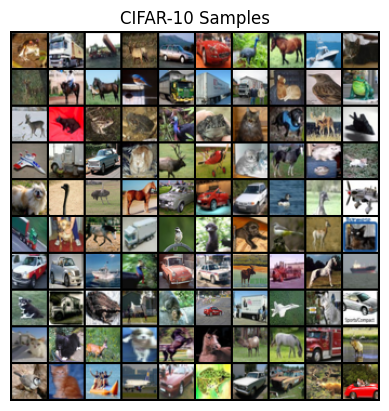

In [5]:
visualize_q2_data()

In [2]:
from model_cifar import UNet


In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from normalizer import DataNormalizer
train_data,test_data=load_q2_data()
train_data=train_data.data
test_data=test_data.data
train_normalizer=DataNormalizer(data_min=np.min(train_data),data_max=np.max(train_data))
test_normalizer=DataNormalizer(data_min=np.min(test_data),data_max=np.max(test_data))
print("Train Normalizer Parameters")
print(train_normalizer.data_min,train_normalizer.data_max)
print("Test Normalizer Parameters")
print(test_normalizer.data_min,test_normalizer.data_max)
train_data_normalized=train_normalizer.normalize(train_data)
test_data_normalized=test_normalizer.normalize(test_data)
print(train_data_normalized.shape,test_data_normalized.shape)
print(train_data_normalized.min(),train_data_normalized.max())
print(test_data_normalized.min(),test_data_normalized.max())


Train Normalizer Parameters
0 255
Test Normalizer Parameters
0 255
(50000, 32, 32, 3) (10000, 32, 32, 3)
-1.0 1.0
-1.0 1.0


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from trainer import ModelTrainer    
train_data_torch = torch.from_numpy(train_data_normalized).float()
test_data_torch = torch.from_numpy(test_data_normalized).float()
train_data_torch=train_data_torch.permute(0,3,1,2)
test_data_torch=test_data_torch.permute(0,3,1,2)
    
    # Create model and trainer
model = UNet(
    in_channels=3,  # For RGB images
    hidden_dims=[64, 128, 256, 512],  # As specified in the homework
    blocks_per_dim=2  # As specified in the homework
)

trainer = ModelTrainer(model, device, train_data_torch, test_data_torch, 
                           batch_size=256, lr=1e-3,warmup_steps=100,num_epochs=60)
    
    # Train the model

trainer.load_model('model_test.pth')

512


In [6]:
def sample_ddim(model, step, num_samples, device):
    x = torch.randn(num_samples, 3, 32, 32, device=device) # Ensure shape matches your data (B, C, H, W)
    # Note: The snippet provided used 2 dimensions for x in line 3, usually images are 4D (B,C,H,W)
    # If your model expects flattened vectors, 2 is fine, but UNet usually takes 4D.
    
    ts = torch.linspace(1 - 1e-4, 1e-4, step + 1)
    
    with torch.no_grad():
        for i in range(step):
            t = ts[i].item()
            tm1 = ts[i + 1].item()
            t_batch = torch.ones(num_samples, device=device) * t
            tm1_batch = torch.ones(num_samples, device=device) * tm1
            
            eps_hat = model(x, t_batch)
                
            alpha_t = torch.cos(np.pi * t_batch / 2)
            sigma_t = torch.sin(np.pi * t_batch / 2)
            alpha_tm1 = torch.cos(np.pi * tm1_batch / 2)
            sigma_tm1 = torch.sin(np.pi * tm1_batch / 2)
            
            # Calculate posterior standard deviation (eta_t)
            eta_t = sigma_tm1/sigma_t * torch.sqrt(1 - alpha_t**2/alpha_tm1**2)
            
            eps_t = torch.randn_like(x)
            
            # Predict x0 (x_hat)
            x_hat = (x - sigma_t.view(-1, 1, 1, 1) * eps_hat) / alpha_t.view(-1, 1, 1, 1)
            x_hat = torch.clamp(x_hat, -1, 1) # Clipping
            
            # Calculate coefficient for deterministic path
            noise_scale = sigma_tm1**2 - eta_t**2
            noise_scale = torch.clamp(noise_scale, min=0)
            noise_scale = torch.sqrt(noise_scale)
            
            # Update x (Fixed swapped terms)
            # Reshape scalars to (B, 1, 1, 1) for broadcasting if x is 4D
            a_tm1 = alpha_tm1.view(-1, 1, 1, 1)
            n_s = noise_scale.view(-1, 1, 1, 1)
            e_t = eta_t.view(-1, 1, 1, 1)
            
            x = a_tm1 * x_hat + n_s * eps_hat + e_t * eps_t
            
    return x.detach().cpu().numpy()

In [9]:
model=trainer.model
model.eval()
samples = []
num_samples = 2000
steps = np.power(2, np.linspace(0, 9, 9)).astype(int)
for step in steps:
    samples.append(sample_ddim(model, step, num_samples, device))
samples = np.array(samples)





In [15]:
samples.shape


(9, 2000, 3, 32, 32)

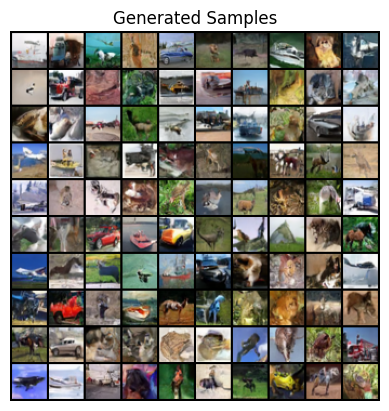

In [17]:
# Get samples from the last diffusion step
# Shape: (N, 3, 32, 32)
samples_final = samples[-1] 

# Transpose to (N, H, W, C) for visualization
samples_final = samples_final.transpose(0, 2, 3, 1)

# Unnormalize: Maps [-1, 1] back to [0, 255]
# Note: The method in normalizer.py is 'unnormalize', not 'denormalize'
samples_unnorm = train_normalizer.unnormalize(samples_final)

# Convert to uint8 (integers 0-255) for image plotting
samples_uint8 = samples_unnorm.astype(np.uint8)

# Visualize the first 100 samples in a grid
show_samples(samples_uint8[:100], title='Generated Samples')


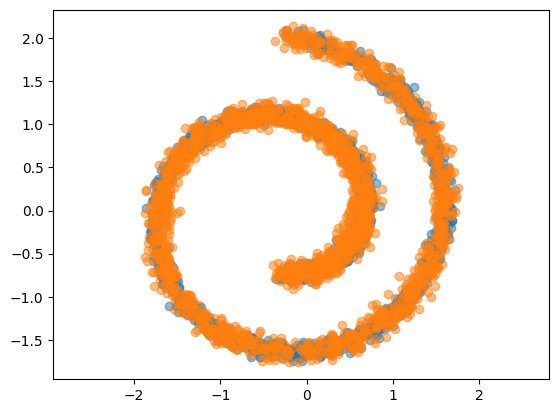

In [14]:
from matplotlib import pyplot as plt
mean = train_data.mean(axis=0, keepdims=True)
std = train_data.std(axis=0, keepdims=True)
train_data_norm = (train_data - mean) / std
plt.scatter(samples[-1][:, 0], samples[-1][:, 1], alpha=0.5)
plt.scatter(train_data_norm[:2000, 0], train_data_norm[:2000, 1], alpha=0.5)
plt.axis('equal')
plt.show()